<a href="https://colab.research.google.com/github/juanlu29/juanlu29/blob/contaminacionMadrid/ajustesParametrosContaminacionMadrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
class datosVisualizacion():
  '''
  Esta clase contiene los datos de entrenamiento y realizaciones de los procesos gaussianos para la visualización de los mismos
  '''
  def __init__(self,Titulo):
    self.x = []
    self.y = []
    self.sigma = []
    self.realizacion_dict = {}
    self.titulo = Titulo
    self.inicializacionPlot()

  def inicializacionPlot(self):
    '''
    Inicializa el objeto matplotlib
    '''
    self.fig,self.ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
    self.ax.set_title(self.titulo)

  def add_covariance(self, cov):
    '''
    Añada matriz de covarianza y alternativamente calcula la covarianza del proceso gaussiano sobre el dominio
    '''

    self.cov_GP = cov

  def add_mean(self,X,Mean):
    '''
    Almacena la desviación estándar de un proceso gausiano dado
    '''
    self.x_mean = X
    self.mean = Mean


  def add_sigma(self,X,Sigma):
    '''
    Almacena la desviación estándar de un proceso gausiano dado
    '''
    self.x_sigma = X
    self.sigma = Sigma
    self.meanMarker = 'r-'

  def add_train_data(self,X,Y):
    self.xtrain = X
    self.ytrain = Y
    self.marker = '*'

  def add_data(self,X,Y,label):
    self.x.append(X)
    self.y.append(Y)
    self.realizacion_dict[label] = len(self.x)-1

  def add_corrPuntoPunto(self,corrPP, corrInputs):
    '''
    Añade correlaciones punto a punto sobre un dominio dado por los valores corrInputs
    '''
    self.corrPP = corrPP
    self.corr_in = corrInputs

  def add_data_plot(self,label):
    try:
      self.ax.plot(self.x[self.realizacion_dict[label]],self.y[self.realizacion_dict[label]],'g--')
    except:
      print('No existe datos referentes a etiqueta :',label)

  def add_train_data_plot(self):
    try:
      self.ax.plot(self.xtrain,self.ytrain,self.marker)
    except:
      print('No existen datos de entrenamiento')

  def add_mean_plot(self):
    try:
      self.ax.plot(self.x_mean,self.mean,self.meanMarker)
    except:
      print('No existen datos de entrenamiento')



  def contorno_sigma(self):
    '''
    Muestra en pantalla contorno de 1 y 2 veces los valores de sigma del proceso gausiano
    '''   

    self.ax.fill_between(self.x_sigma,self.mean - 1.9600 * self.sigma,self.mean + 1.9600 * self.sigma,
             alpha=.45, color='y', edgecolor='None', label='95% confidence interval')
    self.ax.fill_between(self.x_sigma,self.mean - 1.0000 * self.sigma,self.mean + 1.0000 * self.sigma,
             alpha=.35, color='b', edgecolor='None', label='68% confidence interval')
    
  def plotCorrPuntoPunto(self,indices):
    '''
    Visualiza correlaciones punto a punto para los inputs dados por sus indices en la lista indices como argumento del metodo
    '''

    ' Generamos y visualizamos las imagen directamente en este metodo'
    self.fig_cpp, self.ax_cpp = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
    try:
      [self.ax_cpp.plot(self.corr_in,self.corrPP[indice],'-') for indice in indices] 
    except:
      print('No existe datos referentes referentes a correlaciones punto a punto')
    self.ax_cpp.grid(True)
    self.fig_cpp.show()



  def mostrarPlot(self):
    '''
    Muestra plot
    '''
    self.add_mean_plot()
    self.add_train_data_plot()
    self.contorno_sigma()
    self.ax.grid(True)
    self.fig.show()

  def hmapCov(self):
    '''
    Visualiza covarianza como campo bidimensional
    '''
    self.fig_hm, self.ax_hm = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
    plotRange = np.arange(len(self.cov_GP))
    heatmap = self.ax_hm.pcolormesh(self.cov_GP,cmap='RdBu_r')
    self.ax_hm.axis([plotRange.min(), plotRange.max(), plotRange.max(), plotRange.min()])
    self.fig_hm.colorbar(heatmap, ax=self.ax_hm)
    self.fig_hm.show()


In [84]:
class gaussProcess():
  def __init__(self,dominio,observacion,*hiper):
    '''
    Los objetos de esta clase modelan procesos gaussianos caracterizados por su promedio y covarianza
    Como argumento inicial incluimos el data set sobre el que se va a trabajar, su dominio y las observaciones como ndarrays
    '''
    #self.Derivadas = prior_Partial_Der
    self.Kernels = self.kernels()
    # Sea dominio = [x], observacion = [y], matrices columna
    # Se crean matrices [[x],[x],...] (longitud de la concatenacion nx) y [[y],[y],...] (longitud de la concatenacion ny)
    # Nos aseguramos de darle forma de columna
    self.Dominio = np.reshape(dominio,(len(dominio),1))
    self.Observacion = np.reshape(observacion,(len(observacion),1))
    self.Hiper = hiper# Son necesarios para devolver los resultados necesarios en los calculos matriciales
    # Creamos las matrices anteriormente mencionadas
    self.xM = np.full((len(self.Dominio),len(self.Dominio)),self.Dominio)
    self.yM = np.full((len(self.Observacion),len(self.Observacion)),self.Observacion)
    # Los calculos de matrices covariantes seran siempre llamando los metodos pertinentes
    # de la siguiente manera
    # self.calcCovM(xM,xM.T)
    # self.calcDerCovM(xM,xM.T)
    # Tal como la matriz xM ha sido creada antes
    
    self.objetoKernel = self.kernels()
    self.ruidoGausiano = lambda x,y,sigma : self.objetoKernel.ruidoBlanco(x,y,sigma)
    self.vruidoBlanco = np.vectorize(self.ruidoGausiano)

  def calcCovM(self,x1M,x2M):
    '''
    Dados x e y como ndarrays, calcula la matriz de covarianzas cuyos elementos son evaluados de la forma
    C(xi,yi) = (k(xi,yi)) con rango (nx x ny) donde nx y ny son la longitud de los vectores x  e y respectivamente.
    hiper son los hiperparámetros usados en el modelo
    '''
    # Llamamos la funcion Ker que nos debe devolver como salida una matriz cuyos elementos calculados representan k(x,y)
    return self.Ker(x1M,x2M,*self.Hiper)

  def calcDerCovM(self,x1M,x2M):
    '''
    Dados x e y como ndarrays, calcula la matriz correspondiente a la derivada respecto los hiperparámetros de las covarianzas
    cuyos elementos son evaluados de la forma C_j(xi,yi) = (dk(xi,yi)dh_j) con rango (nx x ny) donde nx y ny son la longitud de los 
    vectores x e y respectivamente. Hiper son los hiperparámetros usados en el modelo
    '''
    # Generamos el array de matrices llamando al zip de las funciones de derivadas y sus hiperparámetros para generarlas
    return np.asarray([ self.DerKer[i](x1M,x2M,*self.Hiper) for i in range(len(self.DerKer)) ] )

  def compCov(self,covarianza):
    '''
    Permite definir el kernel a usar por el proceso gaussiano, tanto si es uno de los kernels definidos en la clase como si es una combinacion de los mismos
    El argumento es una funcion anónima en caso de ser una composición, en caso contrario es suficiente con proporcionar el nombre del kernel definido
    hiper son los hiperparámetros que precisan el kernel y vienen dado por un diccionario
    '''
    self.Ker = covarianza # Covarianza definida
    self.Ker = np.vectorize(self.Ker)

  def compDerCov(self,derCovarianza):
    '''
    Permite definir la expresion para la derivada del kernel respecto los distintos hiperparametros como un iterable zip
    de funciones anonimas juntos a sus hiperparámetros. 
    En este caso por propositos de optimizacion se espera que se evalue dinamicamente con distintos hiperparámetros.
    Los datos contenidos en *hiper están encapsulados en una tupla a la que se debe acceder previamente
    '''
    try:
      self.DerKer = derCovarianza
    except:
      raise NameError("No se ha definido kernel previamente")


  class kernels():
    '''
    Se definen kernels de uso común junto a sus hiperparámetros y derivadas asociadas
    '''
    def __init__(self):
      return

    
    def racionalCuadratico(self,xb,xa,s,l,alfa):
      '''
      Correlacion estacionaria (depende solo de la distancia euclidea r = d(xb-xa)) con decaimiento racional con exponente alfa²

      k(xb,xa) = s² (1 + d(xb,xa)²/(2 alfa² l²))^-alfa

      Hiperparámetros:
      s : amplitud de la correlacion, esta relacionado con la amplitud de las trayectorias generadas por el GP
      l : escala de longitud del GP. Esta relacionada con la distancia sobr la cual los procesos generados por el GP pueden presentar oscilaciones o variaciones
      alfa : difusividad de la escala de longitud del GP
      '''
      d = np.linalg.norm(xa-xb)
      return np.power(s,2)*np.power(1+np.power(d,2)/(2*np.power(alfa,2)*np.power(l,2)),-np.power(alfa,2))

    def racCuad_der_alfa(self,xb,xa,s,l,alfa):
      '''
      Derivada respecto el hiperparámetro s de las correlaciones estacionarias  con decaimiento racional con exponente alfa² respecto alfa

      dk(xb,xa)/d alfa = k(xb,xa) ( 2*s/(s + 2) -2 alfa log( k(xb,xa) ) ) ; s = (d(xb,xa)/(alfa l))²

      Hiperparámetros:
      s : amplitud de la correlacion, esta relacionado con la amplitud de las trayectorias generadas por el GP
      l : escala de longitud del GP. Esta relacionada con la distancia sobr la cual los procesos generados por el GP pueden presentar oscilaciones o variaciones
      alfa : difusividad de la escala de longitud del GP
      '''
      correlacion = self.racionalCuadratico(xb,xa,s,l,alfa)
      sumando = np.linalg.norm(xa-xb)
      sumando = np.power(sumando/(alfa*l),2)
      sumando = 2.*sumando/(sumando + 2.)
      return correlacion*(sumando - 2*alfa*np.log(correlacion))


    def racCuad_der_s(self,xb,xa,s,l,alfa):
      '''
      Derivada respecto el hiperparámetro s de las correlaciones estacionarias  con decaimiento racional con exponente alfa² respecto s

      dk(xb,xa)/d s = 2*k(xb,xa)/s

      Hiperparámetros:
      s : amplitud de la correlacion, esta relacionado con la amplitud de las trayectorias generadas por el GP
      l : escala de longitud del GP. Esta relacionada con la distancia sobr la cual los procesos generados por el GP pueden presentar oscilaciones o variaciones
      alfa : difusividad de la escala de longitud del GP
      '''
      correlacion = self.racionalCuadratico(xb,xa,s,l,alfa)
      return 2*(self.racionalCuadratico(xb,xa,s,l,alfa)/s)


    def racCuad_der_l(self,xb,xa,s,l,alfa):
      '''
      Derivada respecto el hiperparámetro s de las correlaciones estacionarias  con decaimiento racional con exponente alfa² respecto l

      dk(xb,xa)/d l = k(xb,xa)⁻¹( d²(xb,xa)/l³)

      Hiperparámetros:
      s : amplitud de la correlacion, esta relacionado con la amplitud de las trayectorias generadas por el GP
      l : escala de longitud del GP. Esta relacionada con la distancia sobr la cual los procesos generados por el GP pueden presentar oscilaciones o variaciones
      alfa : difusividad de la escala de longitud del GP
      '''
      factor = np.linalg.norm(xa-xb)
      factor = np.power(factor,2)/np.power(l,3)
      correlacion = self.racionalCuadratico(xb,xa,s,l,alfa)
      return np.power(correlacion,-1)*factor


    def exponencialSenoCuadratico(self,xb,xa,s,l,p):
      '''
      Correlacion estacionaria (depende solo de la distancia euclidea r = d(xb-xa)) con decaimiento exponencial sinusoidal cuadrático y periodo p

      k(xb,xa) = s² exp( -2 sin²((pi d(xb,xa))/p)/ l² )

      Hiperparámetros:
      s : amplitud de la correlacion, esta relacionado con la amplitud de las trayectorias generadas por el GP
      l : escala de longitud del GP. Esta relacionada con la distancia sobr la cual los procesos generados por el GP pueden presentar oscilaciones o variaciones
      p : periodo de las correlaciones
      '''
      d = np.linalg.norm(xa-xb)
      return np.power(s,2)*np.exp(-2*np.power(np.sin((np.pi*d)/np.power(p,2)),2)/np.power(l,2))

    def expSin_der_s(self,xb,xa,s,l,p):
      '''
      Derivada respecto el hiperparámetro s de las correlaciones estacionarias con decaimiento exponenciales sinusoidales cuadráticas con periodo p

      dk(xb,xa)/ds = 2*k(xb,xa)/s

      Hiperparámetros:
      s : amplitud de la correlacion, esta relacionado con la amplitud de las trayectorias generadas por el GP
      l : escala de longitud del GP. Esta relacionada con la distancia sobr la cual los procesos generados por el GP pueden presentar oscilaciones o variaciones
      p : periodo de las correlaciones
      '''
      return 2*(self.exponencialSenoCuadratico(xb,xa,s,l,p)/s)

    def expSin_der_p(self,xb,xa,s,l,p):
      '''
      Derivada respecto el hiperparámetro p de las correlaciones estacionarias con decaimiento exponenciales sinusoidales cuadráticas con periodo p

      z = (pi * d(xb,xa)) / p²

      dk(xb,xa)/dp = k(xb,xa)*( (-2/l²)*2*sin(z)*cos(z)*(-2 pi d(xb,xa)) / p³)

      Hiperparámetros:
      s : amplitud de la correlacion, esta relacionado con la amplitud de las trayectorias generadas por el GP
      l : escala de longitud del GP. Esta relacionada con la distancia sobr la cual los procesos generados por el GP pueden presentar oscilaciones o variaciones
      p : periodo de las correlaciones
      '''
      d = np.linalg.norm(xb-xa)
      z = (np.pi*d)/np.power(p,2)
      factor = (-2./np.power(l,2))
      factor = 2*factor*np.sin(z)*np.cos(z)*(-2*z/p)
      return self.exponencialSenoCuadratico(xb,xa,s,l,p)*factor

    def expSin_der_l(self,xb,xa,s,l,p):
      '''
      Derivada respecto el hiperparámetro p de las correlaciones estacionarias con decaimiento exponenciales sinusoidales cuadráticas con periodo p

      z = (pi * d(xb,xa)) / p²

      dk(xb,xa)/dl = k(xb,xa)*( (4/l³)*sin²(z) )

      Hiperparámetros:
      s : amplitud de la correlacion, esta relacionado con la amplitud de las trayectorias generadas por el GP
      l : escala de longitud del GP. Esta relacionada con la distancia sobr la cual los procesos generados por el GP pueden presentar oscilaciones o variaciones
      p : periodo de las correlaciones
      '''
      z = np.linalg.norm(xb-xa)
      z = (np.pi*z)/np.power(p,2)
      factor = (4./np.power(l,3))*np.power(np.sin(z),2)
      return self.exponencialSenoCuadratico(xb,xa,s,l,p)*factor

    def exponencialCuadrada(self,xb,xa,s,l):
      '''
      Correlacion estacionaria (depende solo de la distancia r = abs(xb-xa)) con decaimiento exponencial cuadratico

      k(xb,xa) = s² exp( - (xb-xa)²/(2 l²) )

      Hiperparámetros:
      s : amplitud de la correlacion, esta relacionado con la amplitud de las trayectorias generadas por el GP
      l : escala de longitud del GP. Esta relacionada con la distancia sobr la cual los procesos generados por el GP pueden presentar oscilaciones o variaciones
      '''
      return np.power(s,2)*np.exp(-np.power(xa-xb,2)/(2.*np.power(l,2)))

    def expCua_der_s(self,xb,xa,s,l):
      '''
      Derivada respecto el hiperparámetro s de las correlaciones estacionarias con decaimiento exponenciales cuadráticas

      dk(xb,xa)/ds = 2s exp( - (xb-xa)²/(2 l²) )

      Hiperparámetros:
      s : amplitud de la correlacion, esta relacionado con la amplitud de las trayectorias generadas por el GP
      l : escala de longitud del GP. Esta relacionada con la distancia sobr la cual los procesos generados por el GP pueden presentar oscilaciones o variaciones
      '''
      return 2*s*np.exp(-np.power(xa-xb,2)/(2.*np.power(l,2)))

    def expCua_der_l(self,xb,xa,s,l):
      '''
      Derivada respecto el hiperparámetro l de las correlaciones estacionarias con decaimiento exponenciales cuadráticas

      dk(xb,xa)/dl = s²(xb-xa)² / l³ exp( - (xb-xa)²/(2 l²) )

      Hiperparámetros:
      s : amplitud de la correlacion, esta relacionado con la amplitud de las trayectorias generadas por el GP
      l : escala de longitud del GP. Esta relacionada con la distancia sobr la cual los procesos generados por el GP pueden presentar oscilaciones o variaciones
      '''
      return (np.power(s*(xa-xb),2)/np.power(l,3))*np.exp(-np.power(xa-xb,2)/(2.*np.power(l,2)))

    def ruidoBlanco(self,xb,xa,sigma):
      '''
      Correlaciones de ruido blanco o gaussiano puro, solo correlaciona los puntos consigo mismo. 

      k(xb,xa) = sigma² delta(xb,xa)

      Representa incertidumbres intrínsecas en las observaciones y asume una distribución a priori de esos errores gaussiano
      Hiperparáámetros:
      s : amplitud o incertidumbre del ruido generado
      '''
      return np.where(xb==xa, np.power(sigma,2),0.) # Se usa el metodo numpy.where porque las operaciones logicas sobre arrays son consideradas ambiguas en el intérprete de python
                                                    # Esta manera es válidad para python para comprar elemento a elemento entre matrices.

    def rB_der_sigma(self,xb,xa,sigma):
      '''
      Derivada respecto el hiperparámetro sigma del ruido no correlacionado

     dk(xb,xa)/dsigma = sigma² delta(xb,xa)

      Representa incertidumbres intrínsecas en las observaciones y asume una distribución a priori de esos errores gaussiano
      Hiperparáámetros:
      s : amplitud o incertidumbre del ruido generado
      '''
      return np.where(xb==xa, 2*sigma,0.) # Se usa el metodo numpy.where porque las operaciones logicas sobre arrays son consideradas ambiguas en el intérprete de python
                                          # Esta manera es válidad para python para comprar elemento a elemento entre matrices.

 
  def cholDescomp(self,K):
    '''
    Descomposicion cholesky de una matriz dada
    '''
    try:
      L = scipy.linalg.cholesky(K, lower=True)
    except:
      print("La matriz tiene autovalores negativos")
      eigK = scipy.linalg.eigvals(K)
      # Autovalores negativos
      #eigK = np.where(eigK > 0.,np.amax(eigK),-eigK)
      # Parte real, en valor absoluto, del autovalor negativo de mayor amplitud
      negIndx = np.where(np.real(eigK)<0)
      nEigK = eigK[negIndx]
      nEigK_max = np.amax(nEigK) # Valor negativo mas alto
      print(nEigK_max)
      nnEigK_max = np.abs(nEigK_max)
      print("El autovalor con parte real negativa de mayor amplitud es :",nEigK_max,nnEigK_max)
      # Añadimos un termino de ruido independiente sobre el dominio de amplitud cuadrada igual al valor del autovalor negativo mayor
      L = scipy.linalg.cholesky(K + np.diag(nnEigK_max*10000*np.ones(int(np.sqrt(K.size)))), lower=True)

    return L

  def calcInvK(self,matriz):
    '''
    Calculo de la inversa de matriz. 
    '''
    # Calculo de matriz inversa de la covarianza. 
    try:
      invK = np.linalg.inv(matriz)
    except:
      raise NameError("No es posible calcular matriz inversa")

    return invK


  def condicionarGP(self,dominio_test):
    '''
    Dadas unas observaciones junto a sus valores de dominio (uni-dimensionales) en el rango sobre el que se modela el GP, 
    obtiene la covarianza asociada a la distribución de trayectorias condicionadas al conjunto de partida dado un dominio 
    de test en el que queremos comprobar la predicción. Por tanto permite generar las trayectorias compatibles con los datos

    También calcula el logaritmo de la probabilidad de verosimilitud marginal (marginal likelihood) de las observaciones dados los inputs 
    y parámetros del modelo usado.

    Este algoritmo esta especificado en el libro "Gaussian Processes for Machine Learning", como algoritmo 2.1
    '''
    
    # Por la vectorizacion en el cálculo de las matrices de covarianza, el argumento cuando se tiene un kernel
    # evaluado entre elementos que difieren de dimension, cada uno de estos argumentos debe ocupar
    # un array de dimension del producto final
    # kernel(A,B) = {kernel(a,b)} con a, b elementos de A,B respectivamente implica
    # self.calc(A*,B*) con A*,B* con dimensiones A x B
    # -
    cross_test = np.full((len(self.Dominio),len(dominio_test)),dominio_test)
    # -    
    cross_dominio = np.full((len(self.Dominio),len(dominio_test)),self.Dominio)
    # El producto vectorizado
    self.Cov_obs_test = self.calcCovM(cross_dominio,cross_test)
    # -
    # -
    test = np.reshape(dominio_test,(len(dominio_test),1))
    test = np.full((len(dominio_test),len(dominio_test)),test)
    
    

    # Definimos nueva covarianza
    # Primero se realiza la descomposición cholesky de la adición de la covarianza de la distribución a priori,
    # para lo cual calculamos la matriz de covarianza asociada al dominio de las observaciones sobre si mismo
    # y al cruce del dominio de las observaciones y del test de prediccion.

    try:
      self.Cov_obs_obs = self.calcCovM(self.xM,self.xM.T)
    except:
      raise NameError("Debes especificar primero el kernel que estas usando junto a sus hiperparametros con el metodo self.compCov")

    cholL = self.cholDescomp(self.Cov_obs_obs) 

    # Calculo del vector alfa como solucion del sistema K_obs_obs*alfa = y_entrenamiento usando la descomposición cholesky anterior
    self.Alfa = scipy.linalg.cho_solve((cholL,True),self.Observacion)
    
    # Vector v solución particular del sistema cholL*v = k_test para todos los datos del entrenamiento.
    # Este sistema se resuelve introduciendo k_star no como matriz columna sino como la submatriz calculada como la evaluación de la covarianza a priori de los inputs de los valores a predecir y los inputs del entrenamiento
    v = scipy.linalg.solve_triangular(cholL,self.Cov_obs_test, lower=True)
    
    # Se obtiene el valor promedio del proceso predictivo condicionado a las observaciones
    self.Media_pred = np.matmul(self.Cov_obs_test.T,self.Alfa)

    # Covarianza predictiva o condicionada. El proceso llevado a cabo ha sido obtener la distribución condicionada del GP a las observaciones
    # Intenta calcular directamente la matriz, en caso contrario calcular la matriz de covarianza de la distribucion a priori dado el test
    # Las predicciones las consideramos no sometidas al ruido gaussiano
    try:
      self.Cov_pred = self.Cov_priori - np.matmul(v.T,v) - self.vruidoBlanco(test,test.T,self.Hiper[-1])
    except:
      # En caso que no esté definida o no coincida con la dimensionalidad del test, se recalcula la covarianza a priori
      self.Cov_priori = self.calcCovM(test,test.T) - self.vruidoBlanco(test,test.T,self.Hiper[-1])
      self.Cov_pred = self.Cov_priori - np.matmul(v.T,v) 
    
    # La siguiente matriz descompuesta es necesaria para generar procesos del GP.
    self.L_pred = self.cholDescomp(self.Cov_pred)
  

  def log_prob_verosimilitud_datos(self,hiper):
    '''
    Dadas unas observaciones, kernel e hiperparámetros dados, calcula el logaritmo de la probabilidad de verosimilitud de las observaciones al modelo y sus parámetros
    '''

    # Actualizamos hiperparámetros
    self.Hiper = hiper

    # Primero se realiza la descomposición cholesky de la adición de la covarianza de la distribución a priorir y el término de ruido.
    cholL = np.linalg.cholesky(self.calcCovM(self.xM,self.xM.T)) 

    # Calculo del vector alfa como solucion del sistema K*alfa = y_entrenamiento usando la descomposición cholesky anterior
    alfa = scipy.linalg.cho_solve((cholL,True),self.Observacion)

    # Calculo de la probabilidad de verosimilitud marginal a este modelo y sus parámetros
    y = np.reshape(self.Observacion,(len(self.Observacion)))
    alfa = np.reshape(alfa,(len(alfa)))
    self.log_marg_y = +1.*( 0.5*np.dot(alfa,y) + np.sum(np.log(np.diag(cholL)),axis=0) + (float(len(self.Dominio))/2.)*np.log(2*np.pi))
    return self.log_marg_y

  def der_log_prob_ver_hiper(self,hiper):
    '''
    Derivada del logaritmo de la probabilidad de verosimilitud respecto hiperapametros,
    devuelve un ndarray con cada componenete correspondiendo a la matriz del modelo respecto
    los distintos. La expresion es la siguiente

    1/2 traza[  {alfa*alfa.T - K⁻¹} dK/dh] ; alfa = K⁻¹\y

    '''

    # Actualizamos hiperparámetros
    self.Hiper = hiper

    # Definimos nueva covarianza
    try:    
      covDom = self.calcCovM(self.xM,self.xM.T)
    except:
      raise NameError("Debes especificar primero el kernel que estas usando junto a sus hiperparametros con el metodo self.compCov")


    invCovDom = self.calcInvK(covDom)

    cholL = np.linalg.cholesky(covDom)

    # Calculo del vector alfa como solucion del sistema K_obs_obs*alfa = y_entrenamiento usando la descomposición cholesky anterior
    alfa = scipy.linalg.cho_solve((cholL,True),self.Observacion)

    alfa = np.reshape(alfa,(len(alfa),1))

    self.Der_Hiper = hiper
    # Las observaciones las suponemos que están sometidas a ruido gaussiano o blanco y asi se refleja en las derivadas tambien que estan cargaddas 
    derCovHiper = self.calcDerCovM(self.xM,self.xM.T)
    print(derCovHiper)
    print(derCovHiper[0])
    print(derCovHiper[2])
    return -0.5*np.asarray([np.trace(np.matmul(np.matmul(alfa,alfa.T)-invCovDom,np.asarray(derCovHiper[i])),axis1=0,axis2=1) for i in range(len(self.Hiper))]) # La suma de la traza en un array de mas de 2 dimensiones debe especificarse sobre sus indices. En este caso es dimensióón 3.
    

  def prioriGP(self,dominio_test):
    '''
    Computa los términos necesarios para extraer realizaciones del GP siguiendo la distribución a priori
    '''
    
    
    #self.Media_priori = 60.*np.ones(len(dominio_test))
    self.Media_priori = np.zeros(len(dominio_test))

    self.xtest = np.reshape(dominio_test,(len(dominio_test),1))
    xtest_full = np.full((len(self.xtest),len(self.xtest)),self.xtest)

    try:
      self.Cov_priori = self.calcCovM(xtest_full,xtest_full.T)
    except:
      raise NameError("Debes especificar primero el kernel que estas usando junto a sus hiperparametros con el metodo self.compCov")

    # La siguiente matriz descompuesta es necesaria para generar procesos del GP.
    self.L_priori = self.cholDescomp(self.Cov_priori)


  def procesosPrioriGP(self):
    '''
    Genera realizaciones del proceso gaussiano dada la descomposicion cholesky de la matriz de covarianzas y la media correspondiente
    '''
    # Si no se ha calculado la descomposicióón de la covarianza se llama al método aqui
    try:
      numeros_gaussianos_array = np.random.randn(len(self.xtest))
      numeros_gaussianos_array = np.reshape(numeros_gaussianos_array,(len(numeros_gaussianos_array),1))
      return self.Media_priori +  np.matmul(self.L_priori,numeros_gaussianos_array)
    except:
      raise NameError("No se ha incluido los valores del dominio sobre los que muestrear el proceso o no se ha calculado la descomposición de la covarianza")

  def procesosCondicionadosGP(self):
    '''
    Genera realizaciones del proceso gaussiano dada la descomposicion cholesky de la matriz de covarianzas y la media correspondiente
    '''
    try:
      numeros_gaussianos_array = np.random.randn(len(self.xtest))
      numeros_gaussianos_array = np.reshape(numeros_gaussianos_array,(len(numeros_gaussianos_array),1))
      return self.Media_pred + np.matmul(self.L_pred,numeros_gaussianos_array)
    except:
      raise NameError("El GP no ha sido condicionado a las observaciones")

  def sigmaCalc(self,cov):
    '''
    Desviacion estándar punto a punto del proceso gausiano dado por la matriz de covarianza 
    Es la raiz cuadrado de los elementos de la diagonal de la matriz de covarianzas del proceso generado
    '''
    return np.sqrt(np.diag(cov))


  def correlacionPuntoPunto(self):
    '''
    Obtiene la correlacion punto a punto dado un inputo concreto por el indice i_x
    '''
    try:
      self.corrPP_pred = np.array([ self.K_pred[i,:] for i in range(len(self.K_pred)) ])
    except:
      print(" Proceso gaussiano no entrenado aún, no existe K_pred ")
    self.corrPP_prior = np.array([ self.K_prior[i,:] for i in range(len(self.K_prior)) ])

  
  def derivada_LO_CV(self,*args):
    '''
    Dadas unas observaciones particulares estima la derivada de la suma de los logaritmos de la evaluación de la distribución de probabilidad marginal de verosimilitud a que subconjuntos
    de las observaciones están condicionadas al resto, respecto a los hiperparámetros del modelo. Si se encuentra el máximo de este valor, estamos asegurándonos de que con los hiperparámetros ajustados
    las "predicciones" tras generar trayectorias del proceso gausiano que corresponderían a los subconjuntos excluidos sucesivamente son las más probables que el modelo puede hacer. Al ser la suma, esta optimización 
    es global y abarca la aproximación de observacion/test de todos los subconjuntos.
    '''

    if not isinstance(args[0], np.ndarray):
      raise NameError("Las observaciones dadas para calcular la derivada del logaritmo de la distribución marginal de verosimilitud no es un array con datos")
    else:
      observaciones = args[0]

    # Vector auxiliar alpha y matriz auxiliar Z y la diagonal de la inversa de la distribucion a priori
    try:
      alpha = np.matmul(self.invK,observaciones)
      invK_diag = np.diag(self.invK)
      zeta = [np.matmul(self.invK,self.Derivadas[i]) for i in range(len(self.Derivadas)) ] # Es una lista de matrices
      zeta_K = [np.diag(np.matmul(zeta[i],self.invK)) for i in range(len(self.Derivadas)) ]
      alpha_invK = np.multiply(alpha,1./invK_diag)
    except:
      raise NameError("Necesitas calcular la matriz inversa de covarianzas de la distribución a priori")
    
    termino_1 = [np.matmul(np.matmul(alpha_invK,zeta[i]),alpha) for i in range(len(self.Derivadas)) ] # Debido a Z esto es una lista
    termino_2 = [np.sum(np.multiply(np.multiply(0.5*(1. + np.multiply(np.power(alpha,2),1./invK_diag)),zeta_K[i]),1./invK_diag)) for i in range(len(self.Derivadas)) ] # Debido a zeta_K esto es una lista

    # Calculo. Es el valor de la derivada del logaritmo
    self.derVerLOO = np.asarray([ termino_1[i] + termino_2[i] for i in range(len(self.Derivadas))])
    

In [31]:
# Modulos y constantes

import numpy as np
import random
import scipy
import scipy.linalg
from matplotlib import pyplot as plt
#import seaborn as sns
import pandas as pd


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/datosContaminacionMadrid
La matriz tiene autovalores negativos
(-2.7534235163640812e-14+1.0804920257451857e-12j)
El autovalor con parte real negativa de mayor amplitud es : (-2.7534235163640812e-14+1.0804920257451857e-12j) 1.0808427969899147e-12


LinAlgError: ignored

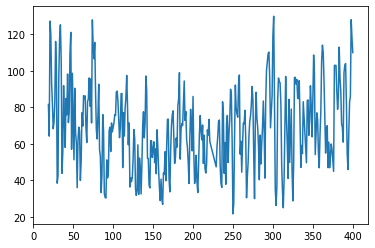

In [ ]:
from google.colab import drive
from scipy.optimize import minimize
drive.mount('/content/drive/')

# Exploramos los directorios de drive. Cambiamos directorio a donde estan los datos
%cd /content/drive/My\ Drive/datosContaminacionMadrid

# Lo pasamos a dataframes
est56NO2_df = pd.read_csv('Est56FL_CodPar08NO2_valuesonly.txt', header=0)


est56NO2_np = est56NO2_df.to_numpy()
est56NO2_np = est56NO2_np[0:400]
est56NO2_np = np.reshape(est56NO2_np,(len(est56NO2_np)))

#est56NO2_np = np.where(est56NO2_np != 0, est56NO2_np,1.)
#rango = np.arange(400)/np.amax(np.arange(400))
#rango = rango - np.sum(rango)/np.float(len(rango))
rango = np.arange(400) + 1

indices = np.where(est56NO2_np != 0.)
est56NO2_np = est56NO2_np[indices]
rango = rango[indices]


plt.plot(rango,est56NO2_np)
#est56NO2_np = est56NO2_np/np.amax(est56NO2_np)
#est56NO2_np = est56NO2_np - np.sum(est56NO2_np)/np.float(len(est56NO2_np))


# Creamos objetos para el ajuste de procesos gaussianos y asociamos kernel junto a sus derivadas
est56NO2_GP = gaussProcess(rango,est56NO2_np,*[60.97403575,40.25049951,0.1])

#est56NO2_GP.compCov(lambda x,y,sh,lh,sigmah : est56NO2_GP.Kernels.exponencialCuadrada(x,y,sh,lh) + est56NO2_GP.Kernels.ruidoBlanco(x,y,sigmah)) # Aqui especificamos los hiperparametros
est56NO2_GP.compCov(lambda x,y,sh,lh,sigmah : est56NO2_GP.Kernels.exponencialCuadrada(x,y,sh,lh)) # Aqui especificamos los hiperparametros
funciones = np.asarray([lambda x,y,sh,lh,sigmah: est56NO2_GP.Kernels.expCua_der_s(x,y,sh,lh), lambda x,y,sh,lh,sigmah: est56NO2_GP.Kernels.expCua_der_l(x,y,sh,lh)])
#funciones = np.asarray([lambda x,y,sh,lh,sigmah: est56NO2_GP.Kernels.expCua_der_s(x,y,sh,lh), lambda x,y,sh,lh,sigmah: est56NO2_GP.Kernels.expCua_der_l(x,y,sh,lh), lambda x,y,sh,lh,sigmah: est56NO2_GP.Kernels.rB_der_sigma(x,y,sigmah)])
est56NO2_GP.compDerCov(funciones)


test = np.linspace(-5,405,1000)
est56NO2_GP.prioriGP(test)
est56NO2_GP.condicionarGP(test)




#for i in range(200):
  #Calculo del mínimo de los hiperparámetros
#  x0 = 50.*np.random.randn(3) # np.array([40.,15.,1.]) + 1.1*np.random.randn(3)
#  res = minimize(est56NO2_GP.log_prob_verosimilitud_datos,x0, method='BFGS', jac=est56NO2_GP.der_log_prob_ver_hiper,options={'xatol': 1e-8,'disp': True})
#  print("hiperparametros que minimizan :",res.x)

sigma_pred = est56NO2_GP.sigmaCalc(est56NO2_GP.Cov_pred)
sigma_prior = est56NO2_GP.sigmaCalc(est56NO2_GP.Cov_priori)

n_r = 1


# A priori
visualizacion_prior = datosVisualizacion("Distribucion a priori")

visualizacion_prior.add_covariance(est56NO2_GP.Cov_priori)
visualizacion_prior.add_sigma(test,sigma_prior)
visualizacion_prior.add_mean(test,est56NO2_GP.Media_priori)
visualizacion_prior.add_train_data(rango,est56NO2_np)

[visualizacion_prior.add_data(test,est56NO2_GP.procesosPrioriGP(),inset) for inset in range(n_r) ]
[visualizacion_prior.add_data_plot(inset) for inset in range(n_r) ] # Visualiza trayectorias obtenidas de la distribución a priori

visualizacion_prior.mostrarPlot() # Muestra incertidumbre de la distribución de trayectorias a priori

# Predictivo
visualizacion_poste = datosVisualizacion("Distribucion a posteriori")

visualizacion_poste.add_covariance(est56NO2_GP.Cov_pred)
visualizacion_poste.add_sigma(test,sigma_pred)
visualizacion_poste.add_mean(test,est56NO2_GP.Media_pred)
visualizacion_poste.add_train_data(rango,est56NO2_np)

[visualizacion_poste.add_data(test,est56NO2_GP.procesosCondicionadosGP(),inset) for inset in range(n_r) ]
#[visualizacion_poste.add_data_plot(inset) for inset in range(n_r) ]

visualizacion_poste.mostrarPlot() # Muestra incertidumbre de la distribución de trayectorias a posteriori
visualizacion_poste.hmapCov()

# Procedemos a maximizar la probabilidad de verosimilitud al modelo de los datos


# In[ ]:


In [ ]:
Probando el kernel sinusoidal

In [85]:
import numpy as np
from scipy.optimize import minimize
from sklearn.datasets import fetch_openml



def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs

date, CO2ppm = load_mauna_loa_atmospheric_co2()


# Creamos objetos para el ajuste de procesos gaussianos y asociamos kernel junto a sus derivadas
hiperparametros = [34.4, 41.8, 3.27, 180., 1., 1.44, 1., 0.446, np.sqrt(17.7), 0.957, 0.197, 0.138, np.sqrt(0.0336)]
sinKer = gaussProcess(np.array(date),np.array(CO2ppm),*hiperparametros)
k = lambda x,y,ss,ll,s,l,so,lo,sh,lh,ph,sr,lr,alfa,sigmah : sinKer.Kernels.exponencialCuadrada(x,y,ss,ll) + sinKer.Kernels.exponencialCuadrada(x,y,s,l) + sinKer.Kernels.exponencialSenoCuadratico(x,y,sh,lh,ph)*sinKer.Kernels.exponencialCuadrada(x,y,so,lo) + sinKer.Kernels.racionalCuadratico(x,y,sr,lr,alfa) + sinKer.Kernels.ruidoBlanco(x,y,sigmah)
sinKer.compCov(k) # Aqui especificamos los hiperparametros
dk11 = lambda x,y,ss,ll,s,l,so,lo,sh,lh,ph,sr,lr,alfa,sigmah: sinKer.Kernels.expCua_der_s(x,y,ss,ll)
dk12 = lambda x,y,ss,ll,s,l,so,lo,sh,lh,ph,sr,lr,alfa,sigmah: sinKer.Kernels.expCua_der_l(x,y,ss,ll)
dk21 = lambda x,y,ss,ll,s,l,so,lo,sh,lh,ph,sr,lr,alfa,sigmah: sinKer.Kernels.expCua_der_s(x,y,s,l)
dk22 = lambda x,y,ss,ll,s,l,so,lo,sh,lh,ph,sr,lr,alfa,sigmah: sinKer.Kernels.expCua_der_l(x,y,s,l)
dk31 = lambda x,y,ss,ll,s,l,so,lo,sh,lh,ph,sr,lr,alfa,sigmah: sinKer.Kernels.expSin_der_s(x,y,sh,lh,ph)*sinKer.Kernels.exponencialCuadrada(x,y,so,lo)
dk32 = lambda x,y,ss,ll,s,l,so,lo,sh,lh,ph,sr,lr,alfa,sigmah: sinKer.Kernels.expSin_der_l(x,y,sh,lh,ph)*sinKer.Kernels.exponencialCuadrada(x,y,so,lo)
dk33 = lambda x,y,ss,ll,s,l,so,lo,sh,lh,ph,sr,lr,alfa,sigmah: sinKer.Kernels.expSin_der_p(x,y,sh,lh,ph)*sinKer.Kernels.exponencialCuadrada(x,y,so,lo)
dk34 = lambda x,y,ss,ll,s,l,so,lo,sh,lh,ph,sr,lr,alfa,sigmah: sinKer.Kernels.expCua_der_s(x,y,so,lo)*sinKer.Kernels.exponencialSenoCuadratico(x,y,sh,lh,ph)
dk35 = lambda x,y,ss,ll,s,l,so,lo,sh,lh,ph,sr,lr,alfa,sigmah: sinKer.Kernels.expCua_der_s(x,y,so,lo)*sinKer.Kernels.exponencialSenoCuadratico(x,y,sh,lh,ph)
dk41 = lambda x,y,ss,ll,s,l,so,lo,sh,lh,ph,sr,lr,alfa,sigmah: sinKer.Kernels.racCuad_der_s(x,y,sr,lr,alfa)
dk42 = lambda x,y,ss,ll,s,l,so,lo,sh,lh,ph,sr,lr,alfa,sigmah: sinKer.Kernels.racCuad_der_l(x,y,sr,lr,alfa)
dk43 = lambda x,y,ss,ll,s,l,so,lo,sh,lh,ph,sr,lr,alfa,sigmah: sinKer.Kernels.racCuad_der_alfa(x,y,sr,lr,alfa)
dk5  = lambda x,y,ss,ll,s,l,so,lo,sh,lh,ph,sr,lr,alfa,sigmah: sinKer.Kernels.rB_der_sigma(x,y,sigmah)
dk = np.array([dk11,dk12,dk21,dk22,dk31,dk32,dk33,dk34,dk35,dk41,dk42,dk43,dk5])
#sinKer.funciones = np.asarray([lambda x,y,sh,lh,ph,sigmah: sinKer.Kernels.expSen_der_s(x,y,sh,lh,ph), lambda x,y,sh,lh,ph,sigmah: sinKer.Kernels.expSen_der_l(x,y,sh,lh,ph), lambda x,y,sh,lh,ph,sigmah: sinKer.Kernels.expSen_der_p(x,y,sh,lh,ph)])
sinKer.compDerCov(dk)

print(sinKer.der_log_prob_ver_hiper(hiperparametros))

dp = 10
po = 1957
pf = 2030
nump = (pf-po)*dp

test = np.linspace(po,pf,nump)
sinKer.prioriGP(test)
sinKer.condicionarGP(test)


# Optimizacion de hiperparametros
x0 = np.array([34.4, 41.8, 3.27, 180., 1., 1.44, 1., 0.446, np.sqrt(17.7), 0.957, 0.197, 0.138, np.sqrt(0.0336)])
res = minimize(sinKer.log_prob_verosimilitud_datos,x0, method='BFGS', jac=sinKer.der_log_prob_ver_hiper,options={'xatol': 1e-8,'disp': True})
print("hiperparametros que minimizan :",res.x)

self.Hiper = res.x
sigma_pred = sinKer.sigmaCalc(sinKer.Cov_pred)
sigma_prior = sinKer.sigmaCalc(sinKer.Cov_priori)


n_r = 1


# A priori
visualizacion_prior = datosVisualizacion("Distribucion a priori")

visualizacion_prior.add_covariance(sinKer.Cov_priori)
visualizacion_prior.add_sigma(test,sigma_prior)
visualizacion_prior.add_mean(test,sinKer.Media_priori)
visualizacion_prior.add_train_data(date,CO2ppm)

[visualizacion_prior.add_data(test,sinKer.procesosPrioriGP(),inset) for inset in range(n_r) ]
[visualizacion_prior.add_data_plot(inset) for inset in range(n_r) ] # Visualiza trayectorias obtenidas de la distribución a priori

visualizacion_prior.mostrarPlot() # Muestra incertidumbre de la distribución de trayectorias a priori


# Predictivo
visualizacion_poste = datosVisualizacion("Distribucion a posteriori")

visualizacion_poste.add_covariance(sinKer.Cov_pred)
visualizacion_poste.add_sigma(test,sigma_pred)
visualizacion_poste.add_mean(test,np.reshape(sinKer.Media_pred,len(sinKer.Media_pred)))
visualizacion_poste.add_train_data(date,CO2ppm)

[visualizacion_poste.add_data(test,sinKer.procesosCondicionadosGP(),inset) for inset in range(n_r) ]
[visualizacion_poste.add_data_plot(inset) for inset in range(n_r) ]

visualizacion_poste.mostrarPlot() # Muestra incertidumbre de la distribución de trayectorias a posteriori




[array([[68.8       , 68.79986328, 68.79945311, ..., 39.95006031,
        39.86702414, 39.78400243],
       [68.79986328, 68.8       , 68.79986328, ..., 40.03311033,
        39.95006031, 39.86702414],
       [68.79945311, 68.79986328, 68.8       , ..., 40.11617354,
        40.03311033, 39.95006031],
       ...,
       [39.95006031, 40.03311033, 40.11617354, ..., 68.8       ,
        68.79986328, 68.79945311],
       [39.86702414, 39.95006031, 40.03311033, ..., 68.79986328,
        68.8       , 68.79986328],
       [39.78400243, 39.86702414, 39.95006031, ..., 68.79945311,
        68.79986328, 68.8       ]])
 array([[0.00000000e+00, 1.12518695e-04, 4.50072095e-04, ...,
        1.78713733e+01, 1.79024926e+01, 1.79334642e+01],
       [1.12518695e-04, 0.00000000e+00, 1.12518695e-04, ...,
        1.78401068e+01, 1.78713733e+01, 1.79024926e+01],
       [4.50072095e-04, 1.12518695e-04, 0.00000000e+00, ...,
        1.78086934e+01, 1.78401068e+01, 1.78713733e+01],
       ...,
       [1.78713733e

ValueError: ignored

Automatically created module for IPython interactive environment
GPML kernel: 66**2 * RBF(length_scale=67) + 2.4**2 * RBF(length_scale=90) * ExpSineSquared(length_scale=1.3, periodicity=1) + 0.66**2 * RationalQuadratic(alpha=0.78, length_scale=1.2) + 0.18**2 * RBF(length_scale=0.134) + WhiteKernel(noise_level=0.0361)
Log-marginal-likelihood: -117.023

Learned kernel: 44.8**2 * RBF(length_scale=51.6) + 2.64**2 * RBF(length_scale=91.5) * ExpSineSquared(length_scale=1.48, periodicity=1) + 0.536**2 * RationalQuadratic(alpha=2.89, length_scale=0.968) + 0.188**2 * RBF(length_scale=0.122) + WhiteKernel(noise_level=0.0367)
Log-marginal-likelihood: -115.050


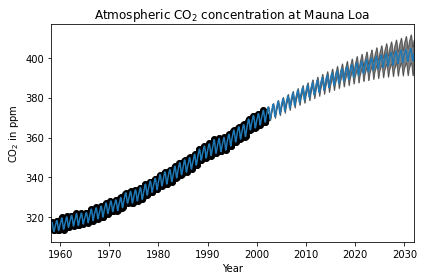

In [12]:
# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#
# License: BSD 3 clause


import numpy as np

from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

print(__doc__)


def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs


X, y = load_mauna_loa_atmospheric_co2()

# Kernel with parameters given in GPML book
k1 = 66.0**2 * RBF(length_scale=67.0)  # long term smooth rising trend
k2 = 2.4**2 * RBF(length_scale=90.0) \
    * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # seasonal component
# medium term irregularity
k3 = 0.66**2 \
    * RationalQuadratic(length_scale=1.2, alpha=0.78)
k4 = 0.18**2 * RBF(length_scale=0.134) \
    + WhiteKernel(noise_level=0.19**2)  # noise terms
kernel_gpml = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0,
                              optimizer=None, normalize_y=True)
gp.fit(X, y)

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

# Kernel with optimized parameters
k1 = 50.0**2 * RBF(length_scale=50.0)  # long term smooth rising trend
k2 = 2.0**2 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                     periodicity_bounds="fixed")  # seasonal component
# medium term irregularities
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-3, np.inf))  # noise terms
kernel = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel, alpha=0,
                              normalize_y=True)
gp.fit(X, y)

print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

X_ = np.linspace(X.min(), X.max() + 30, 1000)[:, np.newaxis]
y_pred, y_std = gp.predict(X_, return_std=True)

# Illustration
plt.scatter(X, y, c='k')
plt.plot(X_, y_pred)
plt.fill_between(X_[:, 0], y_pred - y_std, y_pred + y_std,
                 alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.show()

La matriz tiene autovalores negativos
(-4.6137418889757426e-17+1.1601343889228428e-14j)
El autovalor con parte real negativa de mayor amplitud es : (-4.6137418889757426e-17+1.1601343889228428e-14j) 1.1601435630884636e-14
No existen datos de entrenamiento


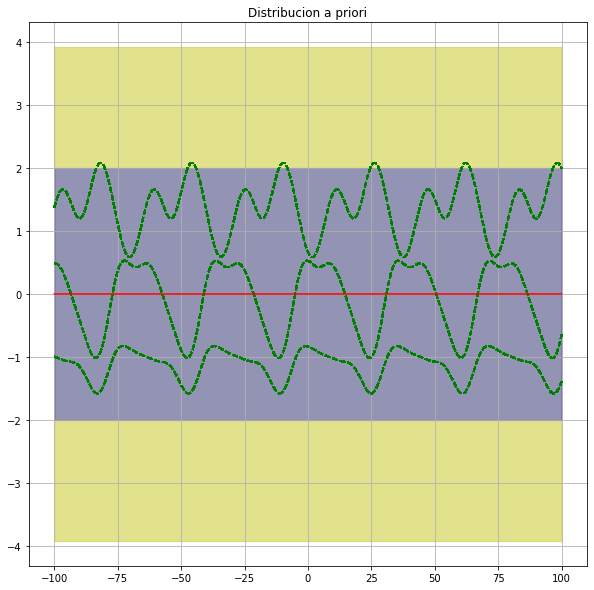

In [33]:


# Creamos objetos para el ajuste de procesos gaussianos y asociamos kernel junto a sus derivadas
ejemplo = gaussProcess(np.array([1,2,3]),np.array([1,2,3,]),*[2.,2.,6., 1.])
k = lambda x,y,sh,lh,ph,sigmah : ejemplo.Kernels.exponencialSenoCuadratico(x,y,sh,lh,ph)
ejemplo.compCov(k) # Aqui especificamos los hiperparametros
dk11 = lambda x,y,so,lo,sh,lh,ph,sigmah: ejemplo.Kernels.expSen_der_s(x,y,sh,lh,ph)
dk12 = lambda x,y,so,lo,sh,lh,ph,sigmah: ejemplo.Kernels.expSen_der_l(x,y,sh,lh,ph)
dk13 = lambda x,y,so,lo,sh,lh,ph,sigmah: ejemplo.Kernels.expSen_der_p(x,y,sh,lh,ph)
dk = np.array([dk11,dk12,dk13,dk21,dk22])
#sinKer.funciones = np.asarray([lambda x,y,sh,lh,ph,sigmah: sinKer.Kernels.expSen_der_s(x,y,sh,lh,ph), lambda x,y,sh,lh,ph,sigmah: sinKer.Kernels.expSen_der_l(x,y,sh,lh,ph), lambda x,y,sh,lh,ph,sigmah: sinKer.Kernels.expSen_der_p(x,y,sh,lh,ph)])
ejemplo.compDerCov(dk)

dp = 10
po = -100
pf = 100
nump = (pf-po)*dp

test = np.linspace(po,pf,nump)
ejemplo.prioriGP(test)

# Optimizacion de hiperparametros

sigma_prior = ejemplo.sigmaCalc(ejemplo.Cov_priori)

n_r = 3


# A priori
visualizacion_prior = datosVisualizacion("Distribucion a priori")

visualizacion_prior.add_covariance(ejemplo.Cov_priori)
visualizacion_prior.add_sigma(test,sigma_prior)
visualizacion_prior.add_mean(test,ejemplo.Media_priori)

[visualizacion_prior.add_data(test,ejemplo.procesosPrioriGP(),inset) for inset in range(n_r) ]
[visualizacion_prior.add_data_plot(inset) for inset in range(n_r) ] # Visualiza trayectorias obtenidas de la distribución a priori

visualizacion_prior.mostrarPlot() # Muestra incertidumbre de la distribución de trayectorias a priori


